In [2]:
# Read from Datasets/ECG5000/ECG5000_TEST.txt

import numpy as np
import matplotlib.pyplot as plt

# Read from Datasets/ECGFiveDays/ECGFiveDays_TEST.txt, and get the first column as the labels
true_labels = np.genfromtxt('Datasets/ECG200/ECG.txt', delimiter=' ', usecols=0)

# Read from Datasets/ECGFiveDays/ECGFiveDays_TEST.txt
data = np.genfromtxt('Datasets/ECG200/ECG.txt', delimiter='  ', usecols=range(1,97))

print(data.shape)


(200, 96)


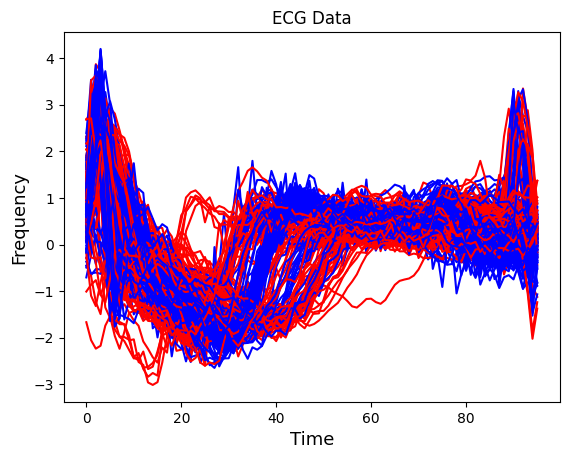

In [3]:
# Plot the data based on the labels
for i in range(1, len(data)):
    if true_labels[i] == 1:
        plt.plot(data[i], '-b')
    else:
        plt.plot(data[i], '-r')
plt.title((
    'ECG Data'))
plt.xlabel('Time', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.show()

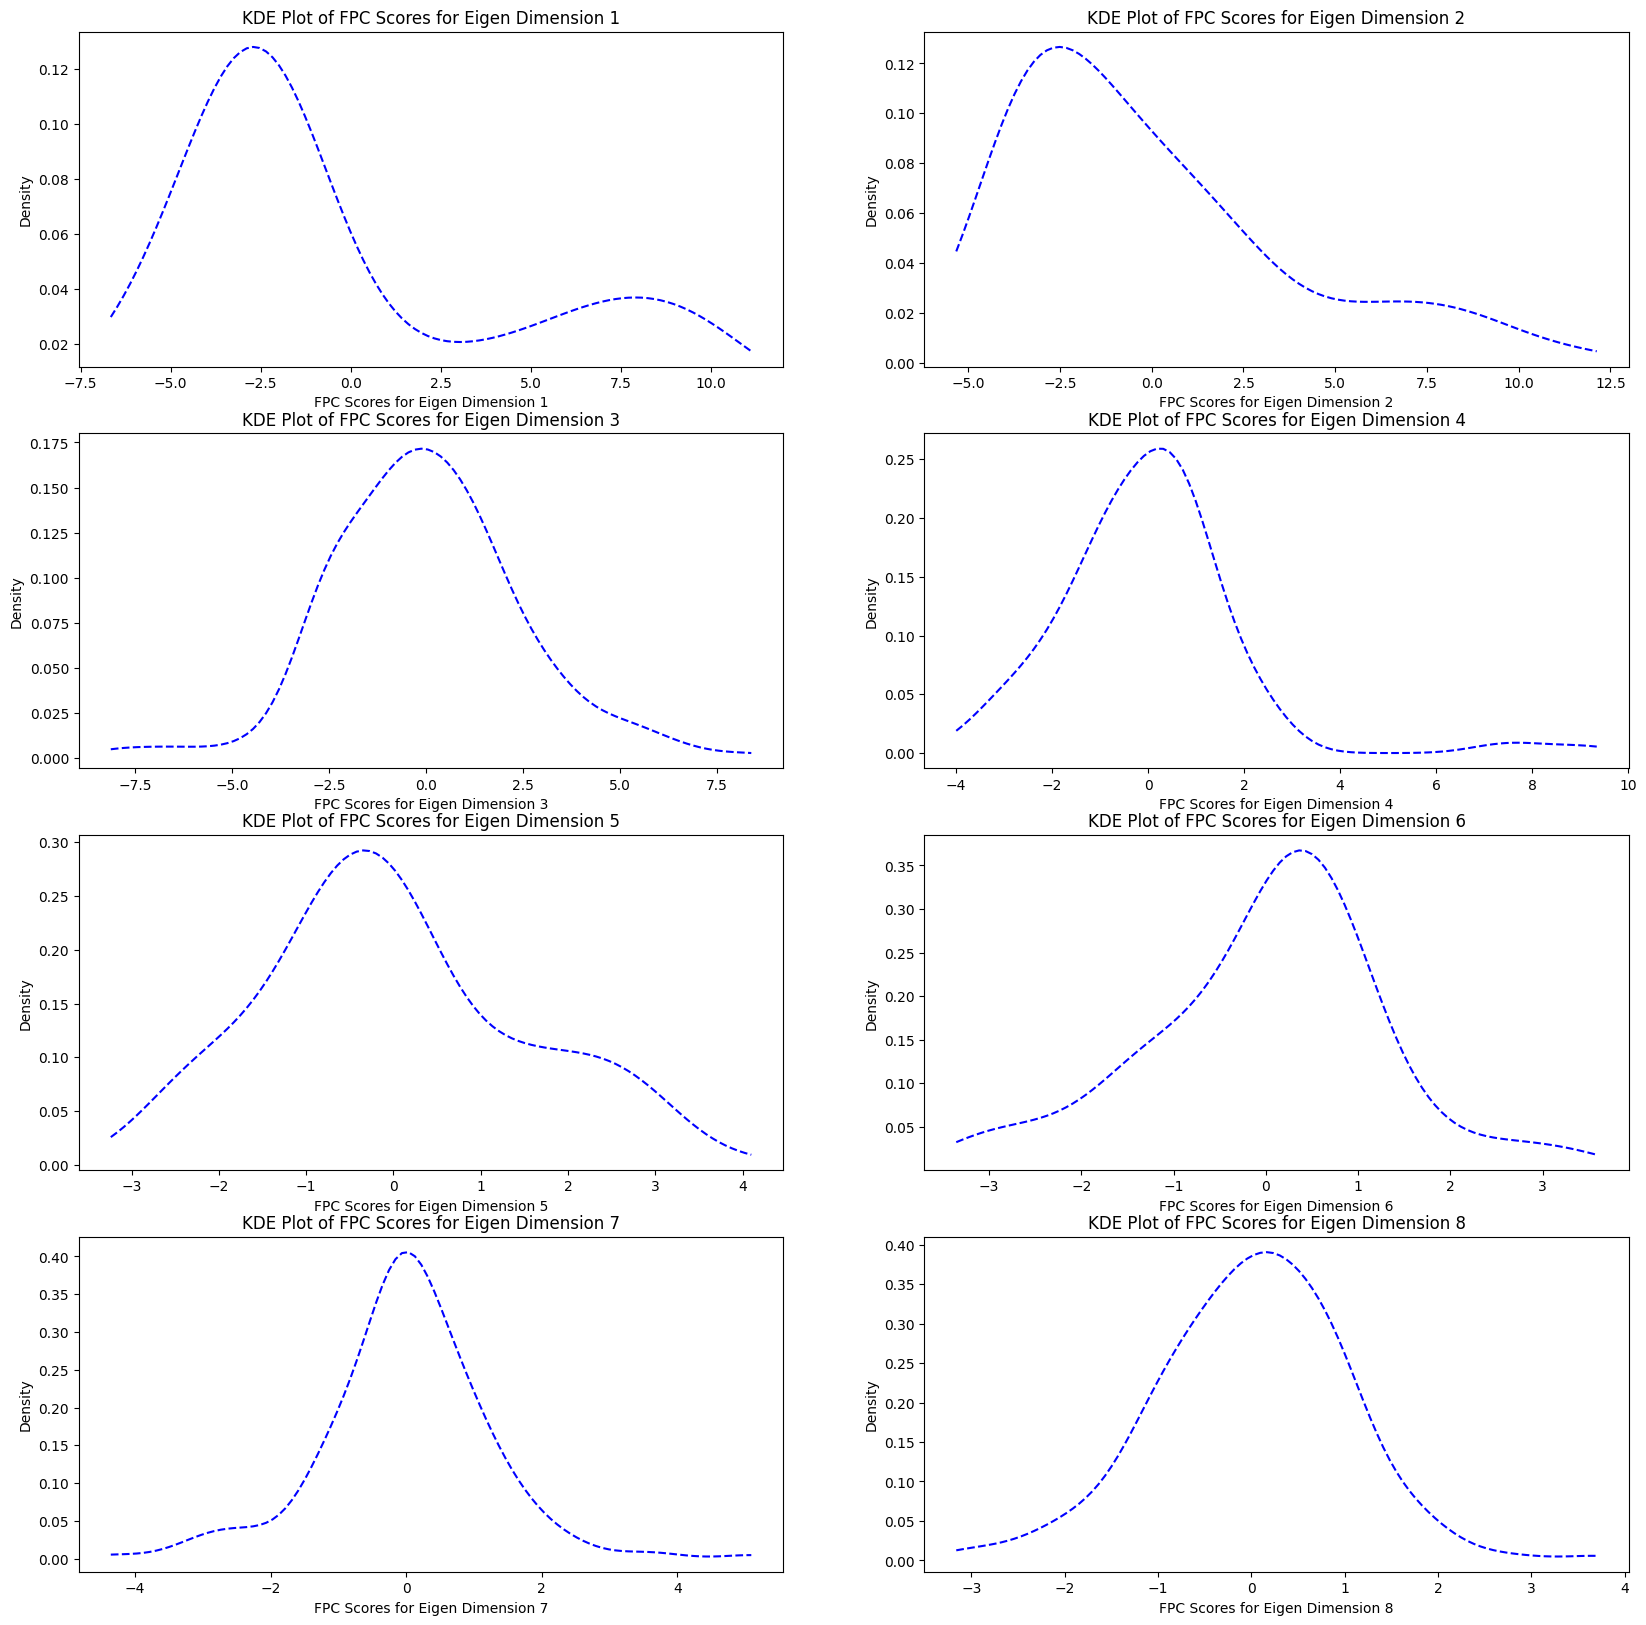

In [6]:
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 10, 150)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i in range(8):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()

Percentage of variation explained by each eigen dimensions:  [0.41813791 0.26836617 0.10633603 0.064662   0.04036533 0.03072924
 0.02660694 0.0187342  0.01633446 0.00972772]


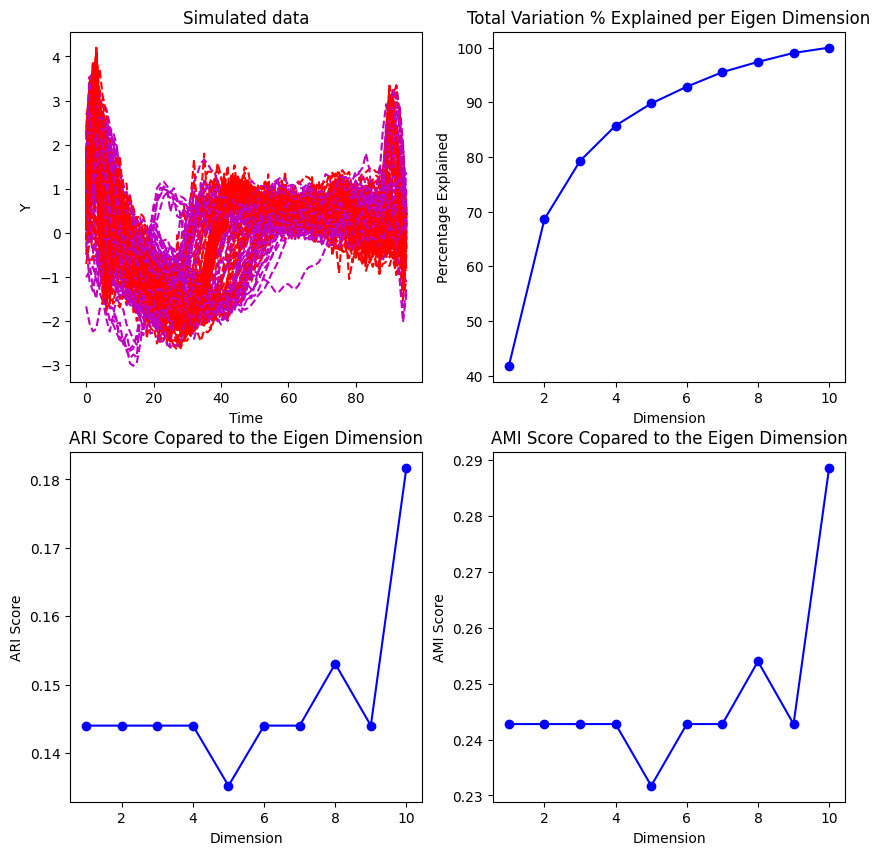

In [44]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, data, 150, true_labels, 2)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, true_labels, data)

In [45]:
# Determine the Eigen Dimension that explains 95% of the variance
for i in range(len(variance)):
    if sum(variance[:i]) >= 0.95:
        print('The Eigen Dimension that explains 95% of the variance is ' + str(i-1))
        V = i -1
        break

The Eigen Dimension that explains 95% of the variance is 7


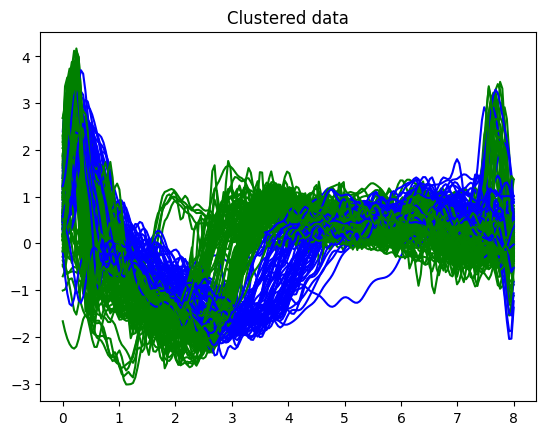

AMI score: 0.144021
ARI score: 0.242761


In [46]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 9, 200)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 2)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-b')
    elif labels[i] == 1:
        plt.plot(t, data_smooth[i], '-g')
    elif labels[i] == 2:
        plt.plot(t, data_smooth[i], '-b')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("AMI score: %f" % adjusted_mutual_info_score(true_labels, labels))
print("ARI score: %f" % adjusted_rand_score(true_labels, labels))

In [41]:
from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.representation.functional_data import DenseFunctionalData

# Ignore the warning
import warnings
warnings.filterwarnings("ignore")

# Make t a dict
t = np.expand_dims(np.linspace(0, 20, len(data[0])), 1)
t = {'input_dim_0': t}
# Change t from (100, 1) to (100,)
t = {k: v.squeeze() for k, v in t.items()}

fcubt_data = DenseFunctionalData(t, data)
# Build the tree
root_node = Node(fcubt_data, is_root=True)
fcubt = FCUBT(root_node=root_node)

# Growing
fcubt.grow(n_components=0.95, min_size=10)

# Joining
fcubt.join(n_components=0.95)

# Get the ARI
print("ARI score for FCUBT: %f" % adjusted_rand_score(true_labels, fcubt.labels_join))
# Get the AMI
print("AMI score for FCUBT: %f" % adjusted_mutual_info_score(true_labels, fcubt.labels_join))

ARI score for FCUBT: 0.328686
AMI score for FCUBT: 0.229600
